# Overview

A simple vanilla RNN Terence Tao who learns how to do grade-school math by asking a `Sensei` for solutions to math problems. `Tutor` creates a random question, while `Sensei` gives the answer. 

Tao is a simple 1-layer vanilla RNN. 


### Surprises and Key Learnings

1. **The initial state of the hidden layer encodes context information**, and it is important to take special care when designing the initializations trategy during training. There are typically three ways to handel the initialization of these states during training:
    a. init to zero every batch
    b. init to random every batch
    c. init to either zero or random at the begining of each Epoch.
    
    I found that init to zero every batch (every training really) is the best way to approach this. If we init only to zero at the begining of every epoch, the initially random behavior of the network means the hidden states will quickly drift away, to a completely context in the parameter space. Therefore it is important to have a hard reset on the context before each training. 
    
    As the network becomes more confidence this might be less of a requirement. 



### Todo:
all done

### Done:
- [x] Add temperature to generator
- [x] get training to work
- [x] use optim and Adam
- [x] add self-feeding generator

In [24]:
import torch
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [25]:
def sensei(query):
    for i, char in enumerate(query):
        if char is "=":
            return "\x00" * (i+1) + str(eval(query[:i]))
def tutor():
    draw = random.random()
    if draw > 0.5:
        return "1+2=?"
    else:
        return "1+1=?"

test = tutor()
answer = sensei(test)
print([answer], len(answer)==len(test))

['\x00\x00\x00\x002'] True


In [26]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.xhh = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.ho = torch.nn.Linear(hidden_size, output_size)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        xs = x.chunk(x.size()[0])
        outputs = []
        for row_vec in xs:
            hidden = self.xhh(torch.cat((row_vec, hidden), 1))
            outputs.append(self.ho(hidden))
        output = torch.cat(outputs, 0)
        return output, hidden
    
    def init_hidden(self, random=False):
        if random:
            return Variable(torch.randn(1, self.hidden_size))
        else:
            return Variable(torch.zeros(1, self.hidden_size)) 
"""                                     
rnn = VanillaRNN(100, 120, 90)
hidden = rnn.init_hidden()
rnn(Variable(torch.randn(1, 100)), hidden, 10)"""

'                                     \nrnn = VanillaRNN(100, 120, 90)\nhidden = rnn.init_hidden()\nrnn(Variable(torch.randn(1, 100)), hidden, 10)'

In [27]:
class Tao():
    def __init__(self, model):
        self.model = model
        self.char2vec = Char2Vec()
        self.loss = 0
        self.losses = []
    
    def init_hidden_(self, random=False):
        self.hidden = model.init_hidden(random)
        return self
    
    def save(self, fn="Vanilla_RNN_Tao.tar"):
        torch.save({
            "hidden": self.hidden, 
            "state_dict": model.state_dict(),
            "losses": self.losses
                   }, fn)
    
    def load(self, fn):
        checkpoint = torch.load(fn)
        self.hidden = checkpoint['hidden']
        model.load_state_dict(checkpoint['state_dict'])
        self.losses = checkpoint['losses']
    
    def setup_training(self, learning_rate):
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_hidden_()
        
    def reset_loss(self):
        self.loss = 0
        
    def forward(self, input_text, target_text):
        
        self.hidden.detach_()
        self.optimizer.zero_grad()
        self.next_(input_text)
        target_vec = Variable(self.char2vec.char_code(target_text))
        self.loss += self.loss_fn(self.output, target_vec)
        
    def descent(self):
        self.loss.backward()
        self.optimizer.step()
        self.losses.append(self.loss.cpu().data.numpy())
        self.reset_loss()
    
    def embed(self, input_data):
        self.embeded = Variable(self.char2vec.one_hot(input_data))
        return self.embeded
        
    def next_(self, input_text):
        self.output, self.hidden = self.model(
            self.embed(input_text)#.view(1, -1, self.model.input_size)
            , self.hidden)
        return self
    
    def softmax_(self, temperature=0.5):
        self.softmax = self.model.softmax(self.output/temperature)
        return self
    
    def text(self, start=None, end=None):
        indeces = torch.multinomial(self.softmax[start:end]).view(-1)
        return self.char2vec.vec2str(indeces)

In [28]:
input_size = 101 # len(char2vec.chars)
hidden_size = input_size

model = VanillaRNN(input_size, hidden_size, input_size)
terence = Tao(model)
# ted.load('./data/Vanilla_RNN_Tao.tar')

In [35]:
learning_rate = 0.2e-3
terence.setup_training(learning_rate)

Epoch 9  input: 1+1=?; output:     2


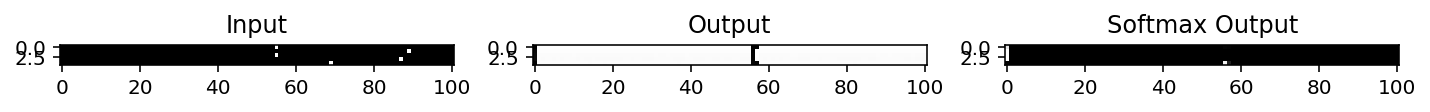

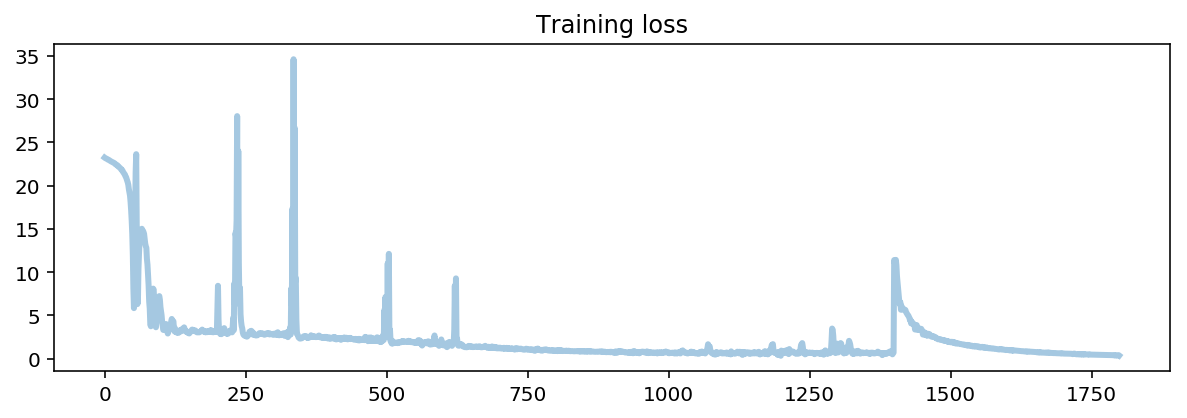

100%|██████████| 100/100 [00:00<00:00, 144.78it/s]

    2


In [80]:
model.zero_grad()
terence.reset_loss()

# seq_length = 10
batches = 100

for epoch_num in range(10):
    
    for step in tqdm(range(batches)):

        source_ = tutor()
        target_ = sensei(source_)
        
        terence.init_hidden_()
        terence.forward(source_, target_)
        
        if step%5 == 4:
            terence.descent()
        
        if step%100 == 99:
            clear_output(wait=True)
            print('Epoch {:d}'.format(epoch_num) + "  input: " + source_ + "; output: " + target_)

            terence.softmax_(1)

            plt.figure(figsize=(12, 9))
            plt.subplot(131)
            plt.title("Input")
            plt.imshow(terence.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(132)
            plt.title("Output")
            plt.imshow(terence.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(133)
            plt.title("Softmax Output")
            plt.imshow(terence.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
            plt.show()
            
            plt.figure(figsize=(10, 3))
            plt.title('Training loss')
            plt.plot(terence.losses, label="loss", linewidth=3, alpha=0.4)
            plt.show()

            print(terence.text(0,150))

## Now use the network to generate text!

In [ ]:
# terence.save('./data/Vanilla_RNN_Tao.tar')

In [81]:
from ipywidgets import widgets
from IPython.display import display

____3
['\x00\x00\x00\x003']


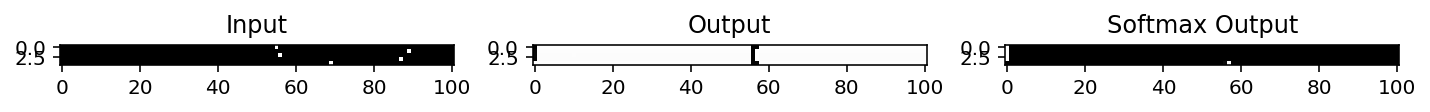

In [84]:
def predict_next(input_text, gen_length=None, temperature=0.05):
    
    if gen_length is None: 
        gen_length = len(input_text)
    
    clear_output(wait=True)
    ted = Tao(model).init_hidden_(random=False)
    
    ted.next_(input_text)
    ted.softmax_()
    string_output = ted.text()
        
    for i in range(1, gen_length - len(input_text)):
        last_char = string_output[-1]
        ted.next_(last_char)
        ted.softmax_(temperature)
        string_output += ted.text()
    
    print(string_output.replace("\x00", "_"))
    print([string_output])
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(ted.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(ted.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(ted.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
    plt.show()


predict_next("1+1=?", 6, 0.01)
predict_next("1+1=?", 6, 0.01)
predict_next("1+1=?", 6, 0.01)
predict_next("1+2=?", 6, 0.01)
predict_next("1+2=?", 6, 0.01)
predict_next("1+2=?", 6, 0.01)

____2____
['\x00\x00\x00\x002\x00\x00\x00\x00']


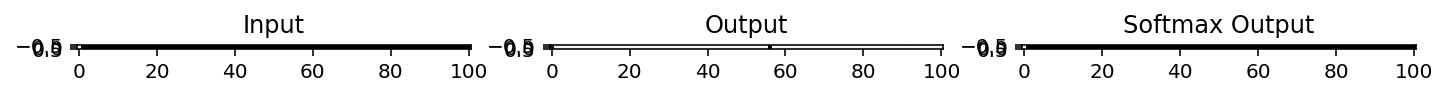

In [85]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    predict_next(text_input.value, 10, temperature=0.005)
    
text_input.on_submit(handle_submit)

We can draw a few key learnings from this!